# Federated GaNDLF Tutorial with PathMNIST Dataset
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/fl-tutorial/blob/gh-pages/tutorial_notebooks/Tutorial_3_GaNDLF_OpenFL_tutorial.ipynb)
### Note: If running the notebook on google colab, please make sure to use python version 3.8, OpenFL works with this version only.

In this tutorial, we will be using the **Generally Nuanced Deep Learning Framework** (GaNDLF) to perform training and inference on a ResNet architecture, with PathMNIST, a dataset of colon pathology images, using [OpenFL](https://github.com/intel/openfl) in a federated learning fashion. This is a multi-class classification task: there are 9 different types of colon tissue displayed in the pathology images, each represented by its own class.

This tutorial demonstrates how to use GaNDLF with a simple classification task. Some steps that would ordinarily be part of the workflow (e.g. data CSV and config YAML file construction) have already been performed for simplicity; please refer to the [GaNDLF documentation](https://cbica.github.io/GaNDLF/) for more details on replication of these steps.

## Dependencies and Packages

Let's get these out of the way first.

In [1]:
# Use latest pip to avoid dependency issues
!python -m pip install -U pip
!(python -m pip install --no-cache-dir \
    pandas \
    matplotlib \
    torch==1.8.2 \
    torchvision==0.9.2 \
    --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111)

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/lts/1.8/cu111


## 1. Familiarize yourself with the Dataset

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label).

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

### 1.1 Download PathMNIST Dataset

The tool will download all datasets. We're mainly interested in `pathmnist`. Feel free to interrupt the execution after it has downloaded `pathmnist`.

In [2]:
# Install medmnist package
!python -m pip install -q medmnist
!python -c "import medmnist; print('MEDMNIST: ', medmnist.__version__)"

# Download medmnist datasets
!python -m medmnist download

MEDMNIST:  2.1.0
Using downloaded and verified file: /home/karan/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/karan/.medmnist/octmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/karan/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/karan/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/karan/.medmnist/organamnist.npz
Using downloaded and verified file: /home/karan/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/organsmnist.npz
Using downloaded and verified file: /home/karan/.medmnist/organmnist3d.npz
Using downloaded and veri

### 1.2 Convert to images

MedMNIST datasets come as a single consolidated `np.ndarray`. We will convert these to `png` images to allow us to use the dataset with `GaNDLF`, a deep learning framework for medical images.

In [3]:
# Convert dataset from numpy to *.png
!(python -m medmnist save \
  --flag=pathmnist \
  --folder=./medmnist/dataset/ \
  --postfix=png)

Saving pathmnist train...
100%|███████████████████████████████████| 89996/89996 [00:33<00:00, 2684.89it/s]
Saving pathmnist val...
100%|███████████████████████████████████| 10004/10004 [00:03<00:00, 2627.28it/s]
Saving pathmnist test...
100%|█████████████████████████████████████| 7180/7180 [00:02<00:00, 2712.49it/s]


### 1.3 Download `train`, `val` and `test` lists

These `csv` files are list of paths to `png` images created earlier, that will be partitioned into their respective splits.

In [4]:
%%bash
# Train CSV list
wget -q --show-progress -O ./medmnist/dataset/train_path_full.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=um4003lkrvyj55jm4a0jz7zsuokb0r8o&file_id=f_991821586980"
echo "Downloaded train list"

# Validation CSV list
wget -q --show-progress -O ./medmnist/dataset/val_path_full.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=rsmff27sm2z34r5xso1jx8xix7nhfspc&file_id=f_991817441206"
echo "Downloaded val list"

# Test CSV list
wget -q --show-progress -O ./medmnist/dataset/test_path_tiny.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=22lm0qfzk5luap72mtdpzx5l3ocflopa&file_id=f_991819617152"
echo "Downloaded test list"


     0K .......... .......... .......... .......... .......... 20%  583K 0s
    50K .......... .......... .......... .......... .......... 40%  218K 0s
   100K .......... .......... .......... .......... .......... 60%  612K 0s
   150K .......... .......... .......... .......... .......... 80%  609K 0s


Downloaded train list


   200K .......... .......... .......... .......... .......   100%  626K=0.6s
     0K .......... .......... .......... .......... .......... 88%  184K 0s


Downloaded val list


    50K ......                                                100%  235K=0.3s


Downloaded test list


     0K .......... .......... .........                       100%  675K=0.04s

We will be using this single-source of images for our Federated Learning experiment. 

To avoid duplication of data at multiple paths for the experiment, we update the paths in all CSVs to reflect full path instead of relative paths. Full path ensures it will be accessible from any location in our runtime.

Essentially, we update `./medmnist` to `/full/path/to/medmnist` in all the 3 CSV files.

In [5]:
import os
import shutil
import numpy as np
import pandas as pd

# Convert ALL paths in the CSV to Absolute paths
csv_files = {
    'train': './medmnist/dataset/train_path_full.csv',
    'val': './medmnist/dataset/val_path_full.csv',
    'test': './medmnist/dataset/test_path_tiny.csv'
}

for path in csv_files.values():
    with open(path, 'r') as f:
        content = f.read()
        content = content.replace('./medmnist', os.path.abspath('./medmnist'))
    
    with open(path, 'w') as f:
        f.write(content)
    print('Updated paths in ', path)

Updated paths in  ./medmnist/dataset/train_path_full.csv
Updated paths in  ./medmnist/dataset/val_path_full.csv
Updated paths in  ./medmnist/dataset/test_path_tiny.csv


### 1.4 Preview Sample Data

Let's use a bit of plotting to see what our data is like.

Below cell helps visualize a few images with their labels. 

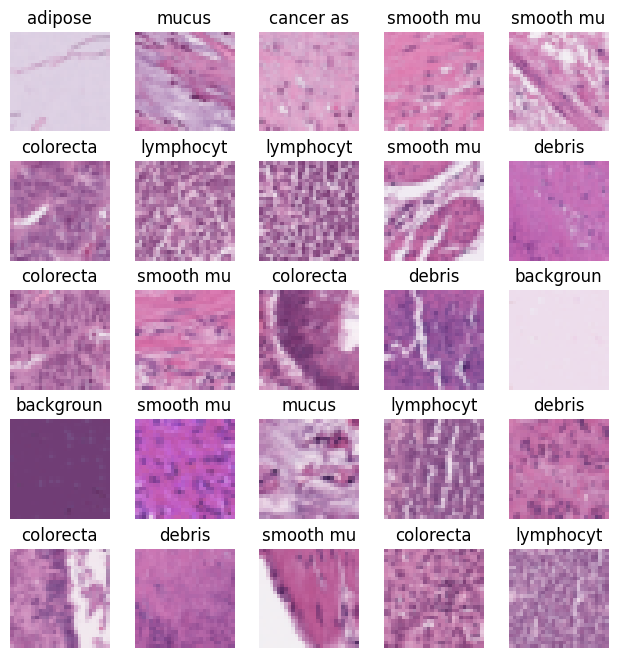

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

n_img = 5
train_samples = pd.read_csv(csv_files['train']).head(n_img*n_img)

label2str = [
    'adipose',
    'background',
    'debris',
    'lymphocytes',
    'mucus',
    'smooth muscle',
    'normal colon mucosa',
    'cancer associated stroma',
    'colorectal adenocarcinoma epithelium'
]

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    filepath = train_samples.iloc[k]['Channel_0']
    label = train_samples.iloc[k]['valuetopredict']
    ax[i, j].imshow(Image.open(filepath))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
fig.subplots_adjust(wspace=0.03, hspace=0.3)


## 2. Federated Learning

Let's install OpenFL and GaNDLF. This will let us train our models and run FL experiments.

Generally Nuanced Deep Learning Framework or GaNDLF is a generalizable application framework for segmentation, regression, and classification using PyTorch. It supports multiple deep learning model architectures, modalities and classes. 

Open Federated Learning (OpenFL) is a Deep Learning framework-agnostic Python3 library for federated learning that enables organizations to collaboratively train a model without sharing sensitive information. Training of statistical models may be done with any deep learning framework, such as TensorFlow or PyTorch, via a plugin mechanism. OpenFL is a community supported project, originally developed by Intel Labs and the Intel Internet of Things Group.

In [7]:
%%bash
# Install OpenFL
rm -rf openfl
git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
cd openfl
python -m pip install .

Cloning into 'openfl'...


Processing /home/karan/workspace/fl-tutorial/tutorial_notebooks/openfl
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for openfl: filename=openfl-1.4-py3-none-any.whl size=615343 sha256=5fe128111bac365c87cb4ffd49b2693b888ed42f108ea0c0bc9bbd4d95dbeccf
  Stored in directory: /tmp/pip-ephem-wheel-cache-_t0do33_/wheels/63/88/54/cd14f60121c308a944503cb09825c66d9f4c92e44e441e9a80
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.4
    Uninstalling openfl-1.4:
      Successfully uninstalled openfl-1.4


In [8]:
%%bash
# Download and install GaNDLF modules
rm -rf GaNDLF
git clone -b 0.0.14 --depth 1 https://github.com/CBICA/GaNDLF.git
cd GaNDLF
git submodule update --init --recursive
echo "Installing GANDLF"
python -m pip install .
python ./gandlf_verifyInstall

Cloning into 'GaNDLF'...
Note: checking out 'bdf7c72c90a0ed0355c2c66ce940db3dac828997'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Submodule 'GANDLF/OPM' (https://github.com/CBICA/OPM.git) registered for path 'GANDLF/OPM'
Submodule 'GANDLF/anonymize/dicomanonymizer' (https://github.com/KitwareMedical/dicom-anonymizer.git) registered for path 'GANDLF/anonymize/dicomanonymizer'
Cloning into '/home/karan/workspace/fl-tutorial/tutorial_notebooks/GaNDLF/GANDLF/OPM'...
Cloning into '/home/karan/workspace/fl-tutorial/tutorial_notebooks/GaNDLF/GANDLF/anonymize/dicomanonymizer'...


Submodule path 'GANDLF/OPM': checked out 'f46ce145128415b0baf893b4782294c90953f251'
Submodule path 'GANDLF/anonymize/dicomanonymizer': checked out '5193ca5409f397e637e4c1a6dfd8f86a09a3cfc4'
Installing GANDLF
Processing /home/karan/workspace/fl-tutorial/tutorial_notebooks/GaNDLF
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for GANDLF: filename=GANDLF-0.0.14-py3-none-any.whl size=162746 sha256=1f0620c58822f3c9ccd03cc8d728aef8875509ca9c8a16f58180b3ca74b98526
  Stored in directory: /tmp/pip-ephem-wheel-cache-83ox6jxd/wheels/03/6f/df/f3f78a986e004f144adeff9ef54ed85aa3bef01ae7dc71d280
Successfully built GANDLF
  Attempting uninstall: GANDLF
    Found existing installation: GANDLF 0.0.14
    Unins

In [9]:
# Verify installations
import sys
gandlf_src = os.path.abspath('./GaNDLF')
sys.path.insert(0, gandlf_src)                # For current kernel python runtime
if 'PYTHONPATH' not in os.environ:
    os.environ['PYTHONPATH'] = ''
os.environ['PYTHONPATH'] += f':{gandlf_src}'  # For shell-invoked python runtime

import GANDLF
print('GaNDLF', GANDLF.__version__)

import openfl
print('OpenFL', openfl.__version__)

GaNDLF 0.0.14
OpenFL 1.4


### 2.1 Create a Federated Learning Workspace

In [10]:
import os
import shutil

# Choose what you like
FL_WORKSPACE_NAME = 'gandlf_example_workspace'
ROUNDS_TO_TRAIN = 2
BATCH_SIZE = 16
DEVICE = 'cpu'

# Create a blank directory with CSV files copied over
workspace_dir = os.path.abspath(os.path.join(os.getcwd(), FL_WORKSPACE_NAME))
if os.path.exists(workspace_dir):
    shutil.rmtree(workspace_dir)
os.mkdir(workspace_dir)

for file in csv_files.values():
    shutil.copy2(file, workspace_dir)
    print(f'Copied `{file}` to workspace `{workspace_dir}`')

Copied `./medmnist/dataset/train_path_full.csv` to workspace `/home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace`
Copied `./medmnist/dataset/val_path_full.csv` to workspace `/home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace`
Copied `./medmnist/dataset/test_path_tiny.csv` to workspace `/home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace`


In [11]:
# Create FL workspace from template
!fx workspace create --prefix $FL_WORKSPACE_NAME --template "gandalf_classification_test" 2>&1

Creating Workspace Directories
Creating Workspace Templates
[16:13:40] INFO     Loading DEFAULTS for section aggregator from file                                                                                ]8;id=350672;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=493860;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#108\108]8;;\
                    /home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl-workspace/workspace/plan/defaults/aggregator.yaml.                
           INFO     Loading DEFAULTS for section assigner from file                                                                                  ]8;id=832457;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=292382;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-

In [12]:
# Certify and Export the workspace
import socket
FQDN = 'localhost'
print(FQDN)
!(cd $workspace_dir &&\
  sed -i "/rounds_to_train/c\    rounds_to_train: $ROUNDS_TO_TRAIN" plan/plan.yaml &&\
  sed -i "/batch_size/c\      batch_size: $BATCH_SIZE" plan/plan.yaml &&\
  sed -i "/device/c\    device: $DEVICE" plan/plan.yaml &&\
  fx plan initialize -a $FQDN &&\
  fx workspace certify &&\
  fx workspace export) | tee 2>&1

localhost
[16:13:43] INFO     FL-Plan hash is 946b1657f911b0a65d783e1bdc692f55342398fc77f87b7573a9dd63517b3ddb6e51a96aa0d44b8172c48b05ee0bd8c1                 plan.py:237
           INFO     Parsing Federated Learning Plan : SUCCESS :                                                                                      plan.py:144
                    /home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace/plan/plan.yaml.                                               
           INFO     aggregator:                                                                                                                      plan.py:148
                      settings:                                                                                                                                 
                        best_state_path: save/fets_seg_test_best.pbuf                                                                                           
                        

### 2.2 Simulating "Silos" of Data
The core idea behind Federated Learning, is to enable training across data silos, without sharing the data itself.

In this tutorial, we will "simulate" silos of data, by partitioning the training set into `N` parts, `N` is as many collaborators are to be simulated.

In real world, this is called Non-IID partitioning. But for simplicity purposes, we will equally partition our data into `N` parts.

Optionally, you could define your own partitioning scheme here.

Note: We assume your data is shuffled before partitioning. If not, you'd be simulating Non-IID conditions!

In [13]:
# Partition the dataset amongst as many collaborators
def data_split(data: np.ndarray, n: int):
    """Equally partition data into n parts"""
    return np.array_split(data, n)

In [14]:
collaborators = ['bob', 'charlie']  # Lowercase names are required
full_list_train = pd.read_csv(csv_files['train'])
train_partitions = data_split(full_list_train.values, n=len(collaborators))
full_list_val = pd.read_csv(csv_files['val'])
val_partitions = data_split(full_list_val.values, n=len(collaborators))

for i, col in enumerate(collaborators):
    # If it exists, clean up and create new
    col_path = os.path.abspath(os.path.join(col, FL_WORKSPACE_NAME))
    if os.path.exists(col_path):
        shutil.rmtree(col_path)
    os.makedirs(col_path)

    # Write train partition as a CSV
    col_list = pd.DataFrame(data=train_partitions[i], columns=full_list_train.columns.values)
    col_csv_path = os.path.join(col_path, 'train_path_full.csv')
    col_list.to_csv(col_csv_path, index=False)

    # Write val partition as a CSV
    col_list = pd.DataFrame(data=val_partitions[i], columns=full_list_val.columns.values)
    col_csv_path = os.path.join(col_path, 'val_path_full.csv')
    col_list.to_csv(col_csv_path, index=False)

    # Copy test/val partition as-is
    shutil.copy2(csv_files['test'], col_path)
    print(f'Train/Test/Val CSV for `{col}` written to {col_path}')

Train/Test/Val CSV for `bob` written to /home/karan/workspace/fl-tutorial/tutorial_notebooks/bob/gandlf_example_workspace
Train/Test/Val CSV for `charlie` written to /home/karan/workspace/fl-tutorial/tutorial_notebooks/charlie/gandlf_example_workspace


### 2.3 Registering Aggregators and Collaborators

This step involves generating certificates, registering them across one another, and preparing individual workspaces of the collaborators.

If you were to do this in a real-world Federation, same steps would apply individually across different devices.

In [15]:
%%bash
# Download config file for training/inference settings
wget -q --show-progress -O config.yaml "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=hs0zwezggl4rxtzgrcaq86enu7qwuvqx&file_id=f_974251081617"

# This file will help plotting and visualizing our results
wget -q --show-progress -O gandlf_collectStats_final "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=avq6pvqg3uzsc4uzbklab66mad6eaik5&file_id=f_989875069231"


     0K .........                                             100%  499K=0.02s
     0K .........                                             100%  743K=0.01s

In [16]:
# Get the path to archives
archive_path = os.path.join(workspace_dir, f'{FL_WORKSPACE_NAME}.zip')
data_path = './medmnist/dataset/pathmnist'

In [17]:
# Import workspace in each collaborator's path
for col in collaborators:
    col_path = os.path.abspath(col)
    col_workspace_path = os.path.join(col_path, FL_WORKSPACE_NAME)
    print('Collaborator: ', col)
    print('Importing workspace')
    !cd $col_path && fx workspace import --archive $archive_path >/dev/null
    
    print(f'Generating collaborator `{col}` certificate')
    !cd $col_workspace_path && fx collaborator generate-cert-request -n $col -d $data_path --silent
    col_cert_path = os.path.join(col_workspace_path, f'col_{col}_to_agg_cert_request.zip')
    !cd $workspace_dir && fx collaborator certify --request-pkg $col_cert_path --silent
  

Collaborator:  bob
Importing workspace
Generating collaborator `bob` certificate
Creating COLLABORATOR certificate key pair with following settings: CN=bob, SAN=DNS:bob
  Moving COLLABORATOR certificate to: /home/karan/workspace/fl-tutorial/tutorial_notebooks/bob/gandlf_example_workspace/cert/col_bob
Archive col_bob_to_agg_cert_request.zip with certificate signing request created
This file should be sent to the certificate authority (typically hosted by the aggregator) for signing

 ✔️ OK
The CSR Hash for file col_bob.csr = b261bef3683e85432c715c5e08fffe5dd6b379d594d607c1dce53071f83e03f24f6f1a4258691adb37b5b62219bf5512
 Signing COLLABORATOR certificate

Registering bob in /home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace/plan/cols.yaml

 ✔️ OK
Collaborator:  charlie
Importing workspace
Generating collaborator `charlie` certificate
Creating COLLABORATOR certificate key pair with following settings: CN=charlie, SAN=DNS:charlie
  Moving COLLABORATOR certificate

In [18]:
# Generate certificate and key-pairs for talking to the aggregator
!cd $workspace_dir && fx aggregator generate-cert-request --fqdn $FQDN
!cd $workspace_dir && fx aggregator certify --fqdn $FQDN --silent

# Import these certificates to the collaborator (so that it can talk to the aggregator)
for col in collaborators:
    col_path = os.path.abspath(os.path.join(col, FL_WORKSPACE_NAME))
    agg_cert_path = os.path.join(workspace_dir, f'agg_to_col_{col}_signed_cert.zip')
    !cd $col_path && fx collaborator certify --import $agg_cert_path

Creating AGGREGATOR certificate key pair with following settings: CN=localhost, SAN=DNS:localhost
  Writing AGGREGATOR certificate key pair to: /home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace/cert/server

 ✔️ OK
The CSR Hash for file server/agg_localhost.csr = e7ddaedde3f104ad4d5e41452ba966797ad580cc65a92f43f54d380a2c36244c7a07d0b78deba5372c6a6772d470aac5
 Signing AGGREGATOR certificate

 ✔️ OK
Certificate col_bob.crt installed to PKI directory

 ✔️ OK
Certificate col_charlie.crt installed to PKI directory

 ✔️ OK


### 2.4 Go!

In [19]:
# Run collaborators
for col in collaborators:
  os.system(f'cd {col}/{FL_WORKSPACE_NAME} && fx collaborator start -n {col} > log.log 2>&1 &')

# Run aggregator
os.system(f'cd {FL_WORKSPACE_NAME} && fx aggregator start > log.log 2>&1 &')

0

### 2.5 Check progress

And wind down after a while.

In [20]:
# Stream aggregator logs
!tail -f $FL_WORKSPACE_NAME/log.log

[16:15:35] INFO     FL-Plan hash is 4390748cae22cba42b7a5a3fb99a05d2c4b65b6d33831da9871ade52e3df9f6827adedbcfb05ab5c85241bded55dd607                 plan.py:237
           INFO     Parsing Federated Learning Plan : SUCCESS :                                                                                      plan.py:144
                    /home/karan/workspace/fl-tutorial/tutorial_notebooks/gandlf_example_workspace/plan/plan.yaml.                                               
           INFO     aggregator:                                                                                                                      plan.py:148
                      settings:                                                                                                                                 
                        best_state_path: save/fets_seg_test_best.pbuf                                                                                           
                        db_store_r

In [ ]:
%%bash
# Optional, kill all fx commands
ps -ax | grep fx
pkill fx

## Summary

We looked at GaNDLF, that internally takes care of model definition, training and validation loops; while OpenFL enables the infrastructure to aggregate models across participants.